In [1]:
### check image resize cifar 10
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [2]:
!nvidia-smi

Sun Sep 15 10:18:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060        Off |   00000000:01:00.0  On |                  N/A |
| N/A   79C    P2             26W /   78W |     526MiB /   6144MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip uninstall torch -y

In [4]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torch-2.4.1%2Bcu124-cp310-cp310-linux_x86_64.whl (797.2 MB)
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.19.1%2Bcu124-cp310-cp310-linux_x86_64.whl (7.1 MB)
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.4.1%2Bcu124-cp310-cp310-linux_x86_64.whl (3.4 MB)
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.0
    Uninstalling torchvision-0.18.0:
      Successfully uninstalled torchvision-0.18.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.3.0
    Uninstalling torchaudio-2.3.0:
      Successfully uninstalled torchaudio-2.3.0


### Torch Tutorial Cifar-10

#### Import functions

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [6]:
torch.set_default_device('cpu') 

In [15]:
device = torch.device('cuda:0')

#### Prepared DataSet

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root="./../data/", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./../data/", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Prepare Model

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, bits):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.hash1 = nn.Linear(120, bits)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(bits, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.hash1(x)
        hash_= self.sigmoid(x);
        x = self.fc2(x)
        return x, hash_

HASH_SIZE = 64
net = Net( HASH_SIZE )
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (hash1): Linear(in_features=120, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

#### Train Parameters

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
iterations = 15

In [19]:
for epoch in range( iterations ):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs, hash_ = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0:
            print(i + 1, " ", end="")
            
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print(f'[{epoch + 1}] loss: {running_loss} accurancy: {100 * correct // total} %')

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1  101  201  301  401  501  601  701  [1] loss: 1791.0972990989685 accurancy: 12 %
1  101  201  301  401  501  601  701  [2] loss: 1593.4229073524475 accurancy: 26 %
1  101  201  301  401  501  601  701  [3] loss: 1379.747588634491 accurancy: 35 %
1  101  201  301  401  501  601  701  [4] loss: 1269.6219915151596 accurancy: 40 %
1  101  201  301  401  501  601  701  [5] loss: 1209.1239671707153 accurancy: 43 %
1  101  201  301  401  501  601  701  [6] loss: 1166.3161437511444 accurancy: 45 %
1  101  201  301  401  501  601  701  [7] loss: 1127.743967294693 accurancy: 47 %
1  101  201  301  401  501  601  701  [8] loss: 1096.5257505178452 accurancy: 49 %
1  101  201  301  401  501  601  701  [9] loss: 1063.354543209076 accurancy: 50 %
1  101  201  301  401  501  601  701  [10] loss: 1031.986235678196 accurancy: 52 %
1  101  201  301  401  501  601  701  [11] loss: 1005.1693268418312 accurancy: 53 %
1  101  201  301  401  501  601  701  [12] loss: 978.0870220661163 accurancy: 55 %
1  101

#### Save Model

In [20]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### Load Model

In [21]:
net = Net( HASH_SIZE ).to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Check visually

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

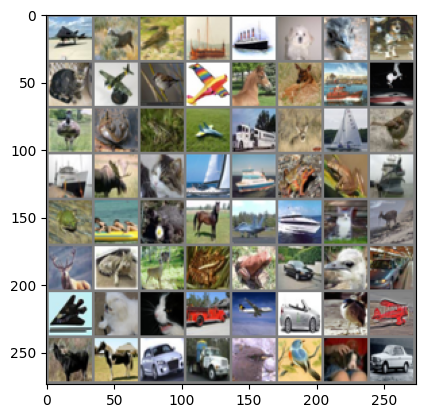

plane deer  deer  ship  ship  dog   bird  horse cat   bird  bird  plane deer  deer  truck bird  bird  frog  frog  plane plane deer  ship  deer  truck deer  cat   ship  ship  frog  frog  cat   frog  plane horse horse ship  plane cat   plane ship  horse deer  frog  deer  car   bird  frog  plane cat   cat   truck plane car   dog   ship  frog  horse car   truck plane bird  cat   car  
tensor([0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [23]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

outputs, hashes = net(images.to(device))
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[predicted[j]]:5s}' for j in range(predicted.shape[0])))
print(torch.round(hashes)[0])

#### Check Accurancy on test set

In [24]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 57 %


In [25]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 68.0 %
Accuracy for class: car   is 73.9 %
Accuracy for class: bird  is 38.4 %
Accuracy for class: cat   is 42.3 %
Accuracy for class: deer  is 47.7 %
Accuracy for class: dog   is 42.6 %
Accuracy for class: frog  is 73.7 %
Accuracy for class: horse is 64.6 %
Accuracy for class: ship  is 71.4 %
Accuracy for class: truck is 54.7 %


### CustomDataSet ( ImageNet )

In [26]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [27]:
IMAGENET_PATH = "../data/Imagenet32_train/"

In [28]:
import os
import _pickle as cPickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    dict_ = unpickle(data_file + str(idx))

    images = dict_['data']
    labels = dict_['labels']

    ## images_without_mean = dict_['mean']   ??? check is there are better results or not

    return images, labels

In [29]:
images2, labels2 = load_databatch(IMAGENET_PATH, 1)

In [30]:
print( type(images2) )
print( type(labels2) )

<class 'numpy.ndarray'>
<class 'list'>


In [31]:
images2 = images2.astype(np.float32).reshape(128116,3,32,32)

In [32]:
dataset = CustomDataset(torch.from_numpy(images2), torch.Tensor(labels2) )

In [33]:
ImageNetLoader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [34]:
correct = 0
total = 0

with torch.no_grad():
    for data in ImageNetLoader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 0 %


### Concat two models

In [35]:
class Net2(nn.Module):
    def __init__(self, bits):
        super().__init__()
        self.fc1 = nn.Linear(2048, 256)
        self.hash1 = nn.Linear(256, bits)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(bits, 10)

    def forward(self, x):
        x = x.to(torch.float32)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.hash1(x)
        hash_= self.sigmoid(x);
        x = self.fc2(x)
        return x, hash_

HASH_SIZE = 64
net2 = Net2( HASH_SIZE )
net2.to(device)

Net2(
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (hash1): Linear(in_features=256, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [36]:
from torchvision import models

resnet50 = models.resnet50(pretrained = True) # weights=ResNet50_Weights.DEFAULT
resnet50 = resnet50.to(device)
resnet50.fc = torch.nn.Identity()

for param in resnet50.parameters():
    param.requires_grad = False

for param in resnet50.fc.parameters():
    param.requires_grad = True
    
for param in resnet50.layer4.parameters():
    param.requires_grad = True

#resnet50

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
net2 = Net2( HASH_SIZE ).to(device)

In [38]:
model2 = nn.Sequential(resnet50, net2)

In [39]:
#model2

In [40]:
# https://discuss.pytorch.org/t/add-layers-on-pretrained-model/88760
# https://stackoverflow.com/questions/53901603/how-to-transfer-weight-of-own-model-to-same-network-but-different-number-of-clas
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492
# https://github.com/flyingpot/pytorch_deephash/blob/master/net.py

#https://www.kaggle.com/code/max237/resnet50-transfer-learning-in-pytorch
#https://datagen.tech/guides/computer-vision/resnet-50/#
#https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351
#https://blog.roboflow.com/how-to-use-resnet-50/
#https://pytorch.org/hub/nvidia_deeplearningexamples_resnet50/

In [42]:
criterion2 = nn.CrossEntropyLoss()
#optimizer2 = optim.AdamW(model2.parameters(), lr=0.000025, weight_decay=50)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
iterations = 50

In [43]:
for epoch in range( 10 ):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer2.zero_grad()

        #if epoch > 1:
        #    for param in model2[0].layer4.parameters():
        #        param.requires_grad = False

        outputs, hash_ = model2(inputs)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        if i % 100 == 0:
            print(i + 1, " ", end="")
            
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print(f'[{epoch + 1}] loss: {running_loss} accurancy: {100 * correct // total} %')

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1  101  201  301  401  501  601  701  

/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)


[1] loss: 1214.7870275378227 accurancy: 45 %
1  101  201  301  401  501  601  701  [2] loss: 736.3574922084808 accurancy: 67 %
1  101  201  301  401  501  601  701  [3] loss: 581.3209108412266 accurancy: 74 %
1  101  201  301  401  501  601  701  [4] loss: 467.5451178252697 accurancy: 78 %
1  101  201  301  401  501  601  701  [5] loss: 372.2016296684742 accurancy: 83 %
1  101  201  301  401  501  601  701  [6] loss: 298.79195303469896 accurancy: 86 %
1  101  201  301  401  501  601  701  [7] loss: 236.1961328983307 accurancy: 89 %
1  101  201  301  401  501  601  701  [8] loss: 197.2737506814301 accurancy: 91 %
1  101  201  301  401  501  601  701  [9] loss: 173.4899787865579 accurancy: 92 %
1  101  201  301  401  501  601  701  [10] loss: 146.6852852962911 accurancy: 93 %


### Save model

In [44]:
PATH = './mainModel.pth'
#PATH = './modelResnetAndCifar.pth' # 45 jeden optimizer, pozniej 2-gi optimizer
#PATH = './modelResnetAndCifar5.pth' # jeden optimizer
torch.save(model2.state_dict(), PATH)

In [45]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = model2(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 70.6 %
Accuracy for class: car   is 77.0 %
Accuracy for class: bird  is 66.0 %
Accuracy for class: cat   is 50.2 %
Accuracy for class: deer  is 67.8 %
Accuracy for class: dog   is 61.7 %
Accuracy for class: frog  is 71.8 %
Accuracy for class: horse is 71.5 %
Accuracy for class: ship  is 80.2 %
Accuracy for class: truck is 77.4 %


In [46]:
correct = 0
total = 0

total_labels = None
total_predictions = None

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %


#### Another try 

In [39]:
resnet50_2 = models.resnet50(pretrained = True)
resnet50_2 = resnet50_2.to(device)

for param in resnet50_2.parameters():
    param.requires_grad = False

resnet50_2.fc = nn.Sequential(nn.Linear(2048, 256),
                         nn.ReLU(),
                         nn.Linear(256, 1),
                         nn.Sigmoid())

In [40]:
for param in resnet50_2.fc.parameters():
    param.requires_grad = True
    
# Unfreeze the last few layers of the model

for param in resnet50_2.layer4.parameters():
    param.requires_grad = True

In [41]:
# https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min
# https://www.kaggle.com/code/max237/resnet50-transfer-learning-in-pytorch

### mAP - evaluate

In [42]:
#https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/object_detection/metrics/mean_avg_precision.py
#https://www.youtube.com/watch?v=FppOzcDvaDI
#https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html
#https://www.v7labs.com/blog/mean-average-precision
#https://yanfengliux.medium.com/the-confusing-metrics-of-ap-and-map-for-object-detection-3113ba0386ef
#https://github.com/flyingpot/pytorch_deephash/blob/master/evaluate.py

#https://medium.com/voice-tech-global/machine-learning-confidence-scores-all-you-need-to-know-as-a-conversation-designer-8babd39caae7

In [43]:
# https://www.youtube.com/watch?v=FppOzcDvaDI
# https://pytorch.org/torcheval/stable/generated/torcheval.metrics.functional.binary_auprc.html
# https://pytorch.org/torcheval/main/generated/torcheval.metrics.functional.multiclass_auprc.html#torcheval.metrics.functional.multiclass_auprc

In [44]:
# praca magisterska
# 1. spor recall - precision
# 2. mAP co to jest 
# 3. PyTorch zapewnia metryki
# 4. dHash, pHash itp.
# 5. trzeci wlasny sens, przyklad w zyciu codziennym czy to ma sens ?

In [45]:
#!pip install torcheval

In [46]:
correct = 0
total = 0

testloader2 = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)

with torch.no_grad():
    for data in testloader2:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 71 %


In [47]:
print(outputs.shape)
print(labels.shape)
print(outputs[0])

torch.Size([10000, 10])
torch.Size([10000])
tensor([-6.0961, -1.5731, -2.0612, 15.8006, -3.6953,  8.7083, -1.1969,  0.5701,
        -2.9815, -2.2048], device='cuda:0')


In [48]:
from torcheval.metrics.functional import multiclass_auprc

In [49]:
print( "mAP value equals to: ", multiclass_auprc(outputs, labels))

mAP value equals to:  tensor(0.7379, device='cuda:0')


### CuNN

In [171]:
from typing import List, Dict, Tuple

class cuNN:
    def __init__(self, size, hash_size, images, size_images ):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = np.zeros([len(images), hash_size ]).astype(np.float32)
        self.hash_size = hash_size
        self.images = images;
        self.size_ = size_images

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)

    def compute_hash(self):
        
        tensor_image = torch.FloatTensor(self.images).to("cuda:0")
        label, hash_ = model2(tensor_image)
        signatures = torch.round(hash_).cpu().detach().numpy().astype(np.int8)
        
        idx = 0
        for signature in signatures:
            self.signatures[idx] = np.packbits( signature ).astype(np.float32)
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures
    
    def compute_candidate(self):
        candidate_pairs = set()
        #list1 = []
        #list2 = []

        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket)
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                               tuple([hash_bucket[i], hash_bucket[j]])
                            )
                            #list1.append(self.signatures[hash_bucket[i]]) 
                            #list2.append(self.signatures[hash_bucket[j]]) 
                            #list1.append(hash_bucket[i]) 
                            #list2.append(hash_bucket[j]) 
        return candidate_pairs
        #return list1, list2
    
    def check_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            item_cpa = np.array(self.signatures[cpa]).astype(np.uint8)
            item_cpb = np.array(self.signatures[cpb]).astype(np.uint8)
            hd = sum(np.bitwise_xor(
                    np.unpackbits(item_cpa), 
                    np.unpackbits(item_cpb)
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [172]:
IMAGES = images2[0:1000]
print(IMAGES.shape)

(1000, 3, 32, 32)


In [173]:
nnLSH = cuNN(16, 8, IMAGES, 1000)
signatures = nnLSH.compute_hash()

pairs = nnLSH.compute_candidate()

print(len(pairs))
duplicates = nnLSH.check_candidate(pairs, 0.9)
print(duplicates[0])
print(len(duplicates))

329523
(164, 700, 0.984375)
866


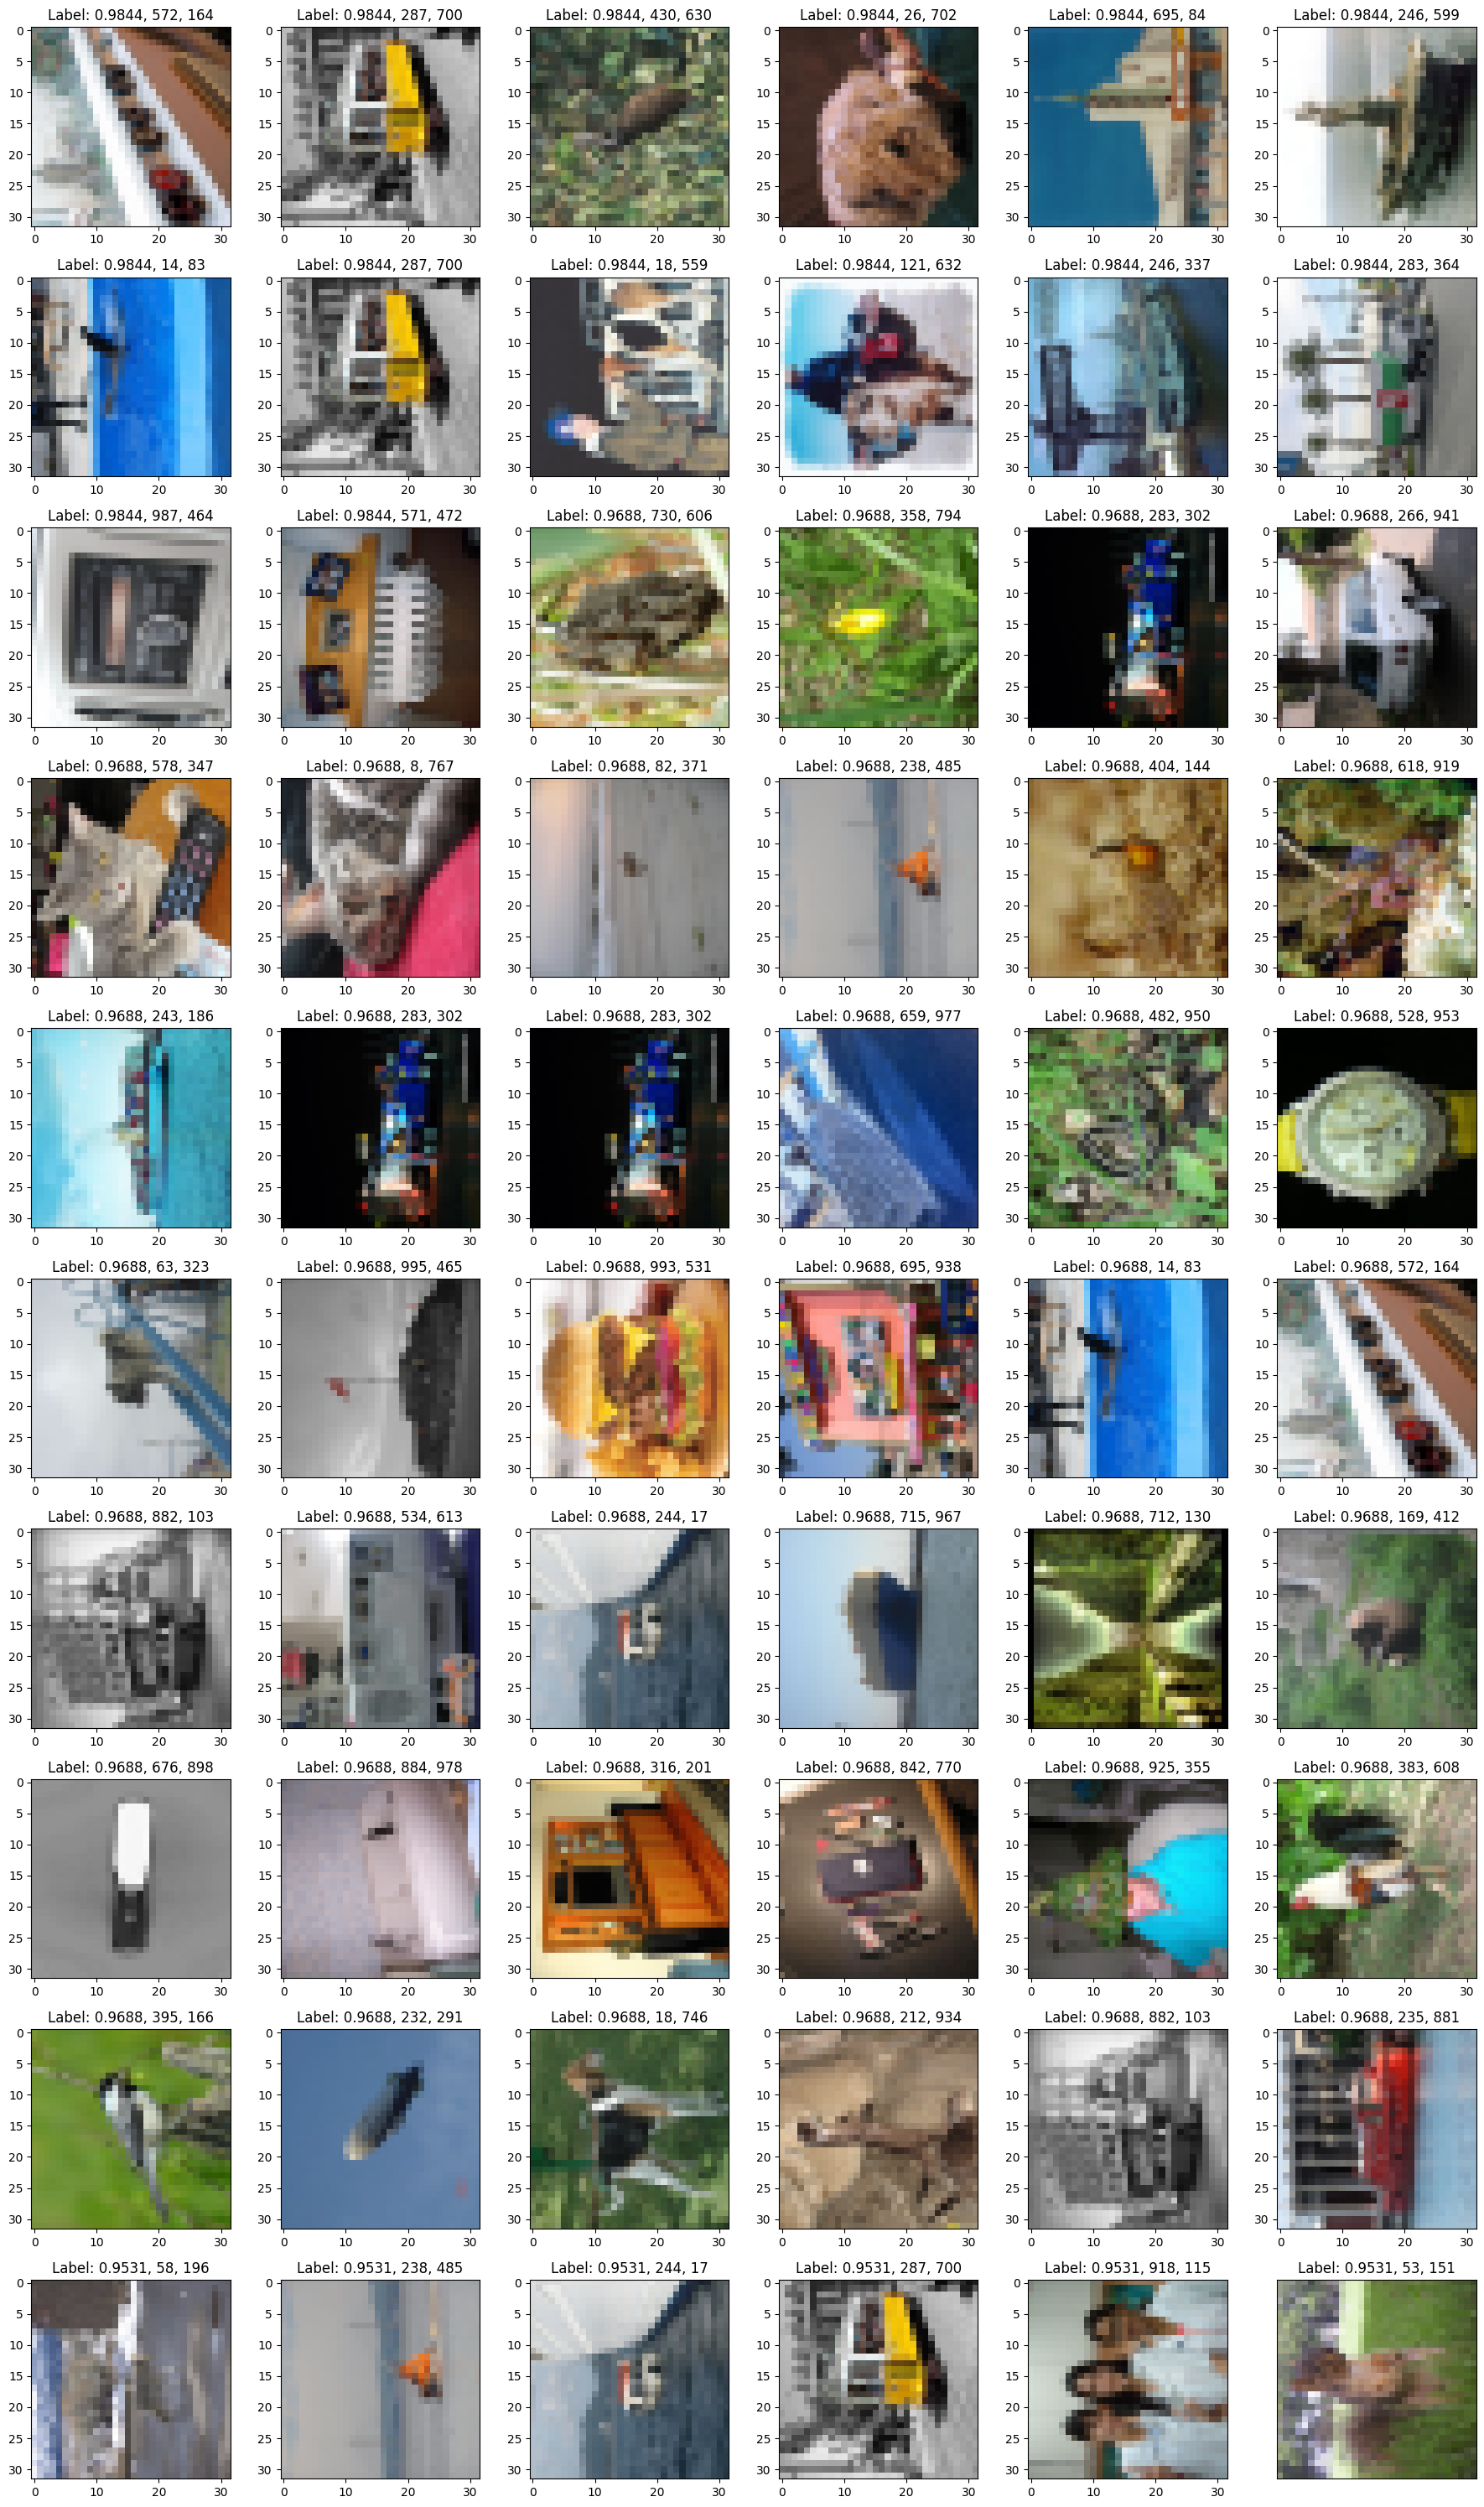

In [174]:
num_row = 10
num_col = 6

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 2):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(IMAGES[duplicates[i//2 + idx_start][0]].astype(np.uint8).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels2[duplicates[i//2 + idx_start][0]]}, {duplicates[i//2 + idx_start][0]}""")

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(IMAGES[duplicates[i//2 + idx_start][1]].astype(np.uint8).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels2[duplicates[i//2 + idx_start][1]]}, {duplicates[i//2 + idx_start][1]}""")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()